In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from PIL import Image,ImageEnhance
from torchvision import transforms
import torch
import torch.nn as nn
import os

In [3]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

--2021-11-26 23:01:19--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.6’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-11-26 23:01:19 (40.8 MB/s) - ‘imagenet_classes.txt.6’ saved [10472/10472]



In [4]:
def preprocess_scale(img, scale = 1.0):
    
    preprocess = transforms.Compose([
            transforms.Resize(int(256*scale)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    return preprocess(img)

def preprocess_translate(img, offset):
    img1 = img.copy()
    img1 = transforms.functional.resize(img1, 256)
    img1 = transforms.functional.crop(img1, top = 32+offset//2, left = 32+offset//2, height=224, width=224)
    preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    return preprocess(img1)

def preprocess_rotate(img, angle=0.0):
    print(angle)
    img1 = img.copy()
    img1 = np.asarray(img1)
    img1 = torch.from_numpy(img1).permute(2, 0, 1)
#     rot = np.array([[np.cos(angle), -np.sin(angle), 0],
#                          [np.sin(angle), np.cos(angle), 0]])


#     rot_mat = rot[None, ...].type(dtype).repeat(img.shape[0],1,1)
#     grid = F.affine_grid(rot_mat, img.size()).type(dtype)
#     img = F.grid_sample(img, grid)
    img1 = transforms.functional.resize(img1, 256)
    img1 = transforms.functional.rotate(img1, angle=angle)
    
    preprocess = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    return preprocess(img)

In [5]:
input_image_names = os.listdir('imagenet-sample-images-master/samples')
input_label_names = [' '.join(x.split('.')[-2].split('_')[1:]) for x in input_image_names]
input_labels = [np.argwhere(categories==' '.join(x.split('.')[-2].split('_')[1:])) for x in input_image_names]
scaled_images = []
translated_images = []
rotated_images = []
for i, img in enumerate(input_image_names):
    input_image = Image.open(f'imagenet-sample-images-master/samples/{img}')
    n_scale = 100
    scaled_images.append([])
    translated_images.append([])
    rotated_images.append([])
    for j in range(n_scale):
        input_tensor = preprocess_scale(input_image, scale=1 + j*1/n_scale)
        input_batch = input_tensor.unsqueeze(0)
        img = np.asarray(transforms.ToPILImage()(input_batch[0]).convert("RGB"), dtype=np.uint8)
#         scaled_images.append(Image.fromarray(img.astype('uint8')))
        scaled_images[i].append(input_batch)
#         plt.imshow(img)
#         plt.show()
    for j in range(-60, 60):
        input_tensor = preprocess_translate(input_image, offset=j)
        input_batch = input_tensor.unsqueeze(0)
        img = np.asarray(transforms.ToPILImage()(input_batch[0]).convert("RGB"), dtype=np.uint8)
        translated_images[i].append(input_batch)
# #         plt.imshow(img)
# #         plt.show()
#     for j in range(360):
#         input_tensor = preprocess_rotate(input_image, angle=j*1.0)
#         input_batch = input_tensor.unsqueeze(0)
#         img = np.asarray(transforms.ToPILImage()(input_batch[0]).convert("RGB"), dtype=np.uint8)
#         plt.imshow(img)
#         plt.show()


In [6]:
class Alex(torch.nn.Module):
    def __init__(self):
        super(Alex, self).__init__()
        pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
        features = list(pretrained.features)
        classifier = list(pretrained.classifier)
        self.features = nn.ModuleList(features).eval() 
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.ModuleList(classifier).eval() 
        
    def forward(self, x):
        self.results = []
        for ii,model in enumerate(self.features):
            x = model(x)
#             if ii in {2,5,7,9,12}:
#                 print(ii, x.shape)
            self.results.append(x.detach().numpy())
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        for ii,model in enumerate(self.classifier):
            if ii in[0,3]:
                continue
            x = model(x)
#             print(ii, x.shape)
#             if ii in {2,5,7,9,12}:
            self.results.append(x.detach().numpy())
        return x, self.results

In [7]:
def get_distance(act1, act2):
    return np.sqrt(np.mean((act1[0] - act2[0])**2))

In [8]:
alex = Alex()
alex.eval()

Using cache found in /home/vamsheedar/.cache/torch/hub/pytorch_vision_v0.10.0


Alex(
  (features): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    

In [9]:
alex, len(alex(scaled_images[0][0])[1])

(Alex(
   (features): ModuleList(
     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
     (1): ReLU(inplace=True)
     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (4): ReLU(inplace=True)
     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU(inplace=True)
     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU(inplace=True)
     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
   (classifier): ModuleList(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=9216, out_features=4

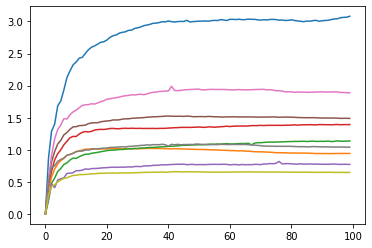

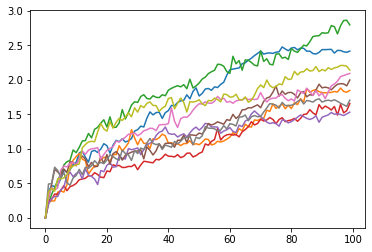

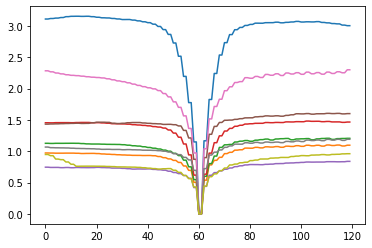

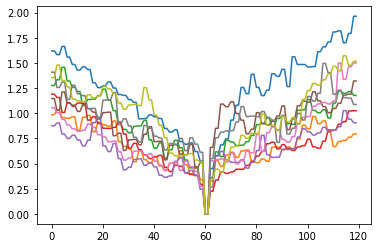

In [15]:
def get_plots(images, n_s, orig=0):
    lengths1 = []
    lengths2 = []
    for i in range(len(input_image_names)):
        lengths1.append([])
        lengths2.append([])
        probs = []
        for j in range(n_s):
            orig_img_op = alex(images[i][orig])
            img_op = alex(images[i][j])
            lengths1[i].append(get_distance(orig_img_op[1][1], img_op[1][1]))
            lengths2[i].append(get_distance(orig_img_op[1][17], img_op[1][17]))
            smax = torch.nn.functional.softmax(img_op[0], dim=1)[0]
            probs.append(smax[input_labels[i]])
    for i in range(len(input_image_names)):
        plt.plot(lengths1[i])
    plt.show()
    for i in range(len(input_image_names)):
        plt.plot(lengths2[i])
    plt.show()
#         plt.plot(probs)
#         plt.show()
#     plt.legend(input_label_names)
#     plt.show()


get_plots(scaled_images, n_scale)
get_plots(translated_images, 120, 60)


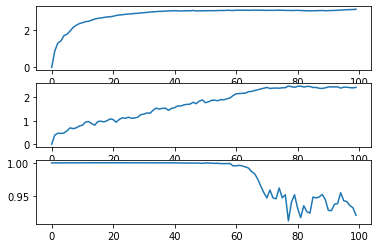

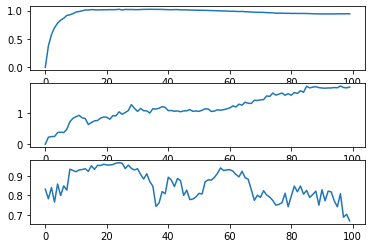

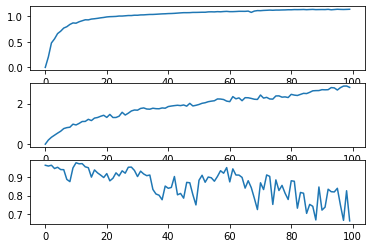

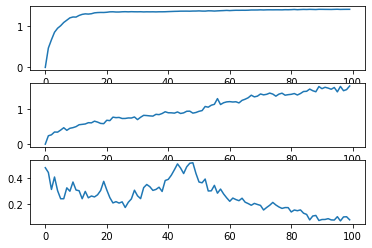

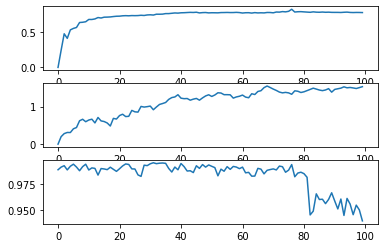

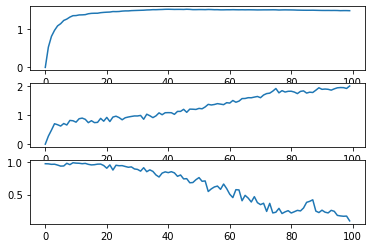

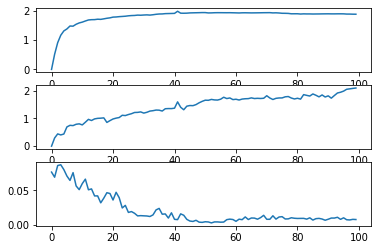

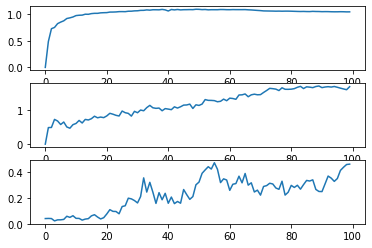

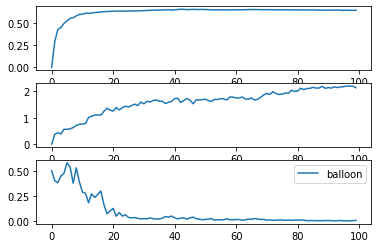

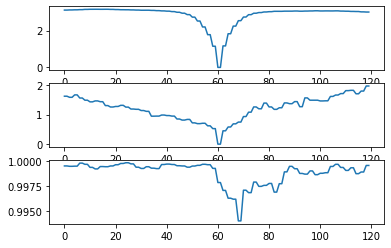

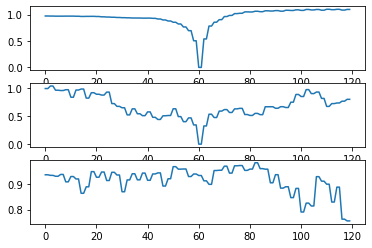

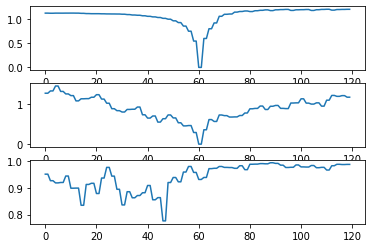

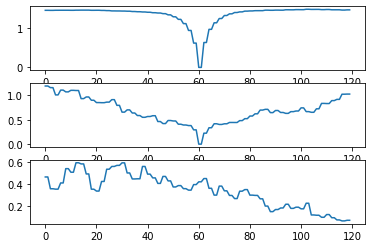

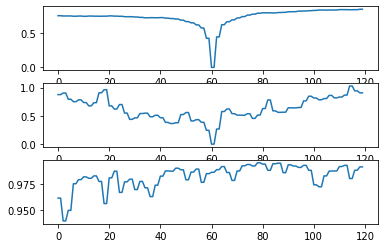

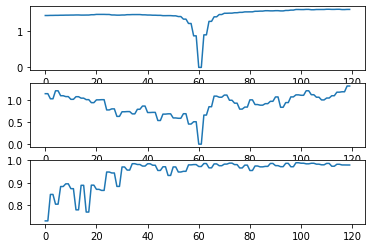

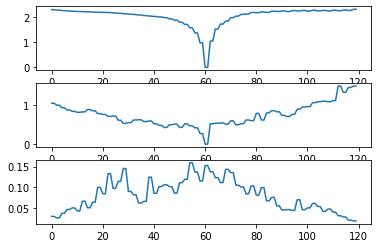

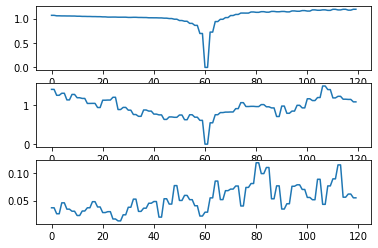

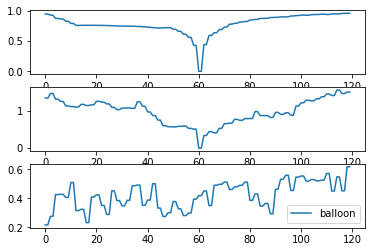

In [106]:
def get_plots(images, n_s, orig=0):
    for i in range(len(input_image_names)):
        lengths1 = []
        lengths2 = []
        probs = []
        gs = gridspec.GridSpec(3, 1)
        pl.figure()
        ax1 = pl.subplot(gs[0, 0]) 
        ax2 = pl.subplot(gs[1, 0]) 
        ax3 = pl.subplot(gs[2, 0]) 
        for j in range(n_s):
            orig_img_op = alex(images[i][orig])
            img_op = alex(images[i][j])
            lengths1.append(get_distance(orig_img_op[1][1], img_op[1][1]))
            lengths2.append(get_distance(orig_img_op[1][17], img_op[1][17]))
            smax = torch.nn.functional.softmax(img_op[0], dim=1)[0]
            probs.append(smax[input_labels[i]])
        ax1.plot(lengths1)
        ax2.plot(lengths2)
        ax3.plot(probs)
    plt.legend(input_label_names)
    plt.show()


get_plots(scaled_images, n_scale)
get_plots(translated_images, 120, 60)
